In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

from kgcnn.literature.GNNExplain import GNNExplainer, GNNInterface
# from kgcnn.utils.adj import precompute_adjacency_scaled, convert_scaled_adjacency_to_list, add_self_loops_to_edge_indices
from kgcnn.literature.GCN import make_model
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from kgcnn.utils.learning import LinearLearningRateScheduler

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering

from kgcnn.data.datasets.mutagenicity import MutagenicityDataset

## Load data

In [2]:
dataset = MutagenicityDataset()
labels, nodes, edge_indices, edges, atoms = dataset.graph_labels, dataset.node_attributes, dataset.edge_indices, dataset.edge_attributes, dataset.node_number
for i in range(len(labels)):
    # edge_indices[i], edges[i] = add_self_loops_to_edge_indices(edge_indices[i], np.expand_dims(edges[i],axis=-1))
    edges[i] = np.expand_dims(edges[i], axis=-1).astype(np.float32) # Make edge feature dimension
for i in range(len(labels)):
    nodes[i] = np.array(
        np.expand_dims(nodes[i],axis=-1) == np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
                        , dtype=np.int) # Make One-Hot encoding

# Train Test split
labels_train, labels_test, nodes_train, nodes_test, edges_train, edges_test, edge_indices_train, edge_indices_test = train_test_split(
    labels, nodes, edges, edge_indices,  train_size=0.8, random_state=1)

# Convert to tf.RaggedTensor or tf.tensor
# a copy of the data is generated by ragged_tensor_from_nested_numpy()
nodes_train, edges_train, edge_indices_train = ragged_tensor_from_nested_numpy(
    nodes_train), ragged_tensor_from_nested_numpy(edges_train), ragged_tensor_from_nested_numpy(
    edge_indices_train)

nodes_test, edges_test, edge_indices_test = ragged_tensor_from_nested_numpy(
    nodes_test), ragged_tensor_from_nested_numpy(edges_test), ragged_tensor_from_nested_numpy(
    edge_indices_test)

xtrain = nodes_train, edges_train, edge_indices_train
xtest = nodes_test, edges_test, edge_indices_test
ytrain = np.expand_dims(labels_train, axis=-1)
ytest = np.expand_dims(labels_test, axis=-1)
print([x.shape for x in xtrain])
print([x.shape for x in xtest])
print(ytrain.shape, ytest.shape)

INFO:kgcnn: Dataset directory located at C:\Users\Patrick\.kgcnn\datasets
INFO:kgcnn: Dataset directory found... done
INFO:kgcnn: Dataset found... done
INFO:kgcnn: Directory for extraction exists... done
INFO:kgcnn: Not extracting zip file ... stopped
INFO:kgcnn: Shift start of graph id to zero for Mutagenicity to match python indexing.
INFO:kgcnn: Graph index which has unconnected [  38  133  166  171  220  246  268  278  286  296  302  305  309  339
  357  439  470  497  527  706  743  783  815  861  878  902  918 1029
 1040 1044 1057 1085 1193 1233 1329 1394 1431 1525 1528 1532 1609 1645
 1696 1915 1971 2024 2026 2036 2069 2133 2138 2142 2143 2174 2193 2210
 2234 2258 2360 2422 2440 2471 2482 2483 2503 2553 2559 2604 2627 2673
 2687 2720 2738 2808 2824 2878 2925 2959 3012 3018 3034 3037 3051 3079
 3114 3118 3142 3208 3217 3310 3344 3349 3371 3380 3381 3395 3477 3498
 3534 3538 3556 3571 3677 3683 3701 3782 3827 3855 3863 3869 3938 3955
 3971 4019 4030 4036 4051 4075 4131 4267 4331] 

## Make and train GCN

INFO:kgcnn: Updated model kwargs:
{'depth': 3,
 'gcn_args': {'activation': 'relu',
              'has_unconnected': True,
              'is_sorted': False,
              'pooling_method': 'mean',
              'units': 64,
              'use_bias': True},
 'input_embedding': {'edge': {'input_dim': 10, 'output_dim': 64},
                     'node': {'input_dim': 55, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 14)},
            {'dtype': 'float32',
             'name': 'edge_attributes',
             'ragged': True,
             'shape': (None, 1)},
            {'dtype': 'int64',
             'name': 'edge_indices',
             'ragged': True,
             'shape': (None, 2)}],
 'name': 'GCN',
 'output_embedding': 'graph',
 'output_mlp': {'activation': ['relu', 'relu', 'sigmoid'],
                'units': [140, 70, 1],
                'use_bias': [True, True, False]},
 'verbose': 

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
node_attributes (InputLayer)    [(None, None, 14)]   0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 64)     960         node_attributes[0][0]            
__________________________________________________________________________________________________
edge_attributes (InputLayer)    [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
edge_indices (InputLayer)       [(None, None, 2)]    0                                            
______________________________________________________________________________________________

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/gather_nodes_outgoing_2/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/gcn_2/gather_nodes_outgoing_2/Reshape:0", shape=(None, 64), d

109/109 - 4s - loss: 0.6588 - accuracy: 0.6013
Epoch 2/150
109/109 - 1s - loss: 0.6146 - accuracy: 0.6867
Epoch 3/150
109/109 - 1s - loss: 0.5948 - accuracy: 0.6936
Epoch 4/150
109/109 - 1s - loss: 0.5776 - accuracy: 0.6982
Epoch 5/150
109/109 - 1s - loss: 0.5537 - accuracy: 0.7169
Epoch 6/150
109/109 - 1s - loss: 0.5496 - accuracy: 0.7215
Epoch 7/150
109/109 - 1s - loss: 0.5263 - accuracy: 0.7380
Epoch 8/150
109/109 - 1s - loss: 0.5237 - accuracy: 0.7368
Epoch 9/150
109/109 - 1s - loss: 0.5202 - accuracy: 0.7411
Epoch 10/150
109/109 - 2s - loss: 0.5119 - accuracy: 0.7475 - val_loss: 0.5166 - val_accuracy: 0.7558
Epoch 11/150
109/109 - 1s - loss: 0.5044 - accuracy: 0.7527
Epoch 12/150
109/109 - 1s - loss: 0.5118 - accuracy: 0.7469
Epoch 13/150
109/109 - 1s - loss: 0.5039 - accuracy: 0.7504
Epoch 14/150
109/109 - 1s - loss: 0.4893 - accuracy: 0.7541
Epoch 15/150
109/109 - 1s - loss: 0.4806 - accuracy: 0.7697
Epoch 16/150
109/109 - 1s - loss: 0.4818 - accuracy: 0.7651
Epoch 17/150
109/10

109/109 - 1s - loss: 0.1472 - accuracy: 0.9395
Epoch 130/150
109/109 - 1s - loss: 0.1542 - accuracy: 0.9392 - val_loss: 0.7555 - val_accuracy: 0.7961
Epoch 131/150
109/109 - 1s - loss: 0.1488 - accuracy: 0.9415
Epoch 132/150
109/109 - 1s - loss: 0.1450 - accuracy: 0.9449
Epoch 133/150
109/109 - 1s - loss: 0.1421 - accuracy: 0.9452
Epoch 134/150
109/109 - 1s - loss: 0.1371 - accuracy: 0.9487
Epoch 135/150
109/109 - 1s - loss: 0.1353 - accuracy: 0.9467
Epoch 136/150
109/109 - 1s - loss: 0.1360 - accuracy: 0.9467
Epoch 137/150
109/109 - 1s - loss: 0.1338 - accuracy: 0.9467
Epoch 138/150
109/109 - 1s - loss: 0.1317 - accuracy: 0.9461
Epoch 139/150
109/109 - 1s - loss: 0.1253 - accuracy: 0.9498
Epoch 140/150
109/109 - 1s - loss: 0.1224 - accuracy: 0.9527 - val_loss: 0.8483 - val_accuracy: 0.8122
Epoch 141/150
109/109 - 1s - loss: 0.1194 - accuracy: 0.9530
Epoch 142/150
109/109 - 1s - loss: 0.1219 - accuracy: 0.9521
Epoch 143/150
109/109 - 1s - loss: 0.1205 - accuracy: 0.9536
Epoch 144/150
1

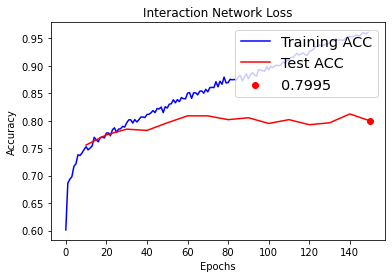

In [3]:
model_args = {'name': "GCN",
                 'inputs': [{'shape': (None, 14), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
                            {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32', 'ragged': True},
                            {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True}],
                 'input_embedding': {"node": {"input_dim": 55, "output_dim": 64},
                                     "edge": {"input_dim": 10, "output_dim": 64}},
                 'output_embedding': 'graph',
                 'output_mlp': {"use_bias": [True, True, False], "units": [140, 70, 1],
                                "activation": ['relu', 'relu', 'sigmoid']},
                 'gcn_args': {"units": 64, "use_bias": True, "activation": 'relu', "pooling_method": 'mean',
                              "is_sorted": False, "has_unconnected": True},
                 'depth': 3, 'verbose': 1
              }
model = make_model(**model_args)

# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 150
epomin = 100
epostep = 10

# Compile model with optimizer and loss
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
print(model.summary())

# Start and time training
start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=2
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Get loss from history
trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])
acc_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.savefig('gcn_explain_mutag_3.png')
plt.show()

## Implement the ExplainableGNN from GNNInterface

In [4]:
class ExplainableGCN(GNNInterface):

    def __init__(self, gnn_model, **kwargs):
        super(ExplainableGCN, self).__init__()
        self.gnn_model = gnn_model

    def predict(self, gnn_input, masking_info=None):
        return self.gnn_model(gnn_input, training=False)[0]

    def masked_predict(self, gnn_input, edge_mask, feature_mask, node_mask, training=False):
        node_input, edge_input, edge_index_input = gnn_input

        masked_edge_input = tf.ragged.map_flat_values(tf.math.multiply, edge_input, edge_mask)
        masked_feature_input = tf.ragged.map_flat_values(tf.math.multiply, tf.dtypes.cast(node_input, tf.float32),
                                                         tf.transpose(feature_mask))
        masked_node_feature_input = tf.ragged.map_flat_values(tf.math.multiply, masked_feature_input, node_mask)
        masked_pred = \
        self.gnn_model([masked_node_feature_input, masked_edge_input, edge_index_input], training=training)[0]

        return masked_pred

    def get_number_of_nodes(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input[0].shape[0]

    def get_number_of_node_features(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input.shape[2]

    def get_number_of_edges(self, gnn_input):
        _, edge_input, _ = gnn_input
        return edge_input[0].shape[0]

    def get_explanation(self, gnn_input, edge_mask, feature_mask, node_mask):
        edge_relevance = np.array(edge_mask[:, 0])
        node_relevance = np.array(node_mask[:, 0])
        feature_relevance = np.array(feature_mask[:, 0])
        features = np.array(gnn_input[0][0])
        edges = np.array(gnn_input[2][0])
        graph = nx.Graph()
        for i, f in enumerate(features):
            graph.add_node(i, features=f, relevance=node_relevance[i])
        for i, e in enumerate(edges):
            if edge_relevance is None:
                graph.add_edge(e[0], e[1])
            else:
                graph.add_edge(e[0], e[1], relevance=edge_relevance[i])
        return graph, feature_relevance

    def present_explanation(self, explanation, threshold=0.5):
        graph = explanation[0]
        # element_labels = np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
        element_labels = ['H', 'Li', 'C', 'N', 'O', 'F', 'Na', 'P', 'S', 'Cl', 'K', 'Ca', 'Br', 'I']
        important_edges = []
        color_map = []
        node_color_map = []
        node_labels = {}
        for (u, v, relevance) in graph.edges.data('relevance'):
            relevance = min(relevance + 0.1, 1.0)
            color_map.append((0, 0, 0, relevance))
        for n, f in graph.nodes.data('features'):
            element = np.argmax(f)
            r, g, b, a = plt.get_cmap('tab20')(element)
            node_color_map.append((r, g, b, graph.nodes[n]['relevance']))
            node_labels[n] = (element_labels[element])
        if np.all(explanation[1] == 1):
            nx.draw_kamada_kawai(graph, edge_color=color_map, labels=node_labels, node_color=node_color_map)
        else:
            f, axs = plt.subplots(2, figsize=(8, 12))
            nx.draw_kamada_kawai(graph, ax=axs[0], edge_color=color_map, labels=node_labels, node_color=node_color_map)
            bar_colors = [plt.get_cmap('tab20')(element) for element in np.arange(14)]
            axs[1].bar(np.array(element_labels), explanation[1], color=bar_colors)

Instanciate a Explainable GNN:

In [5]:
explainable_gcn = ExplainableGCN(model)
compile_options = {'loss': 'binary_crossentropy', 'optimizer': tf.keras.optimizers.Adam(lr=0.2)}
fit_options={'epochs': 100, 'batch_size': 1, 'verbose': 0}
gnnexplaineroptimizer_options = {'edge_mask_loss_weight': 0.001,
                 'edge_mask_norm_ord': 1,
                 'feature_mask_loss_weight': 0,
                 'feature_mask_norm_ord': 1,
                 'node_mask_loss_weight': 0,
                 'node_mask_norm_ord': 1}

explainer = GNNExplainer(explainable_gcn,
                              compile_options=compile_options,
                              fit_options=fit_options,
                              gnnexplaineroptimizer_options=gnnexplaineroptimizer_options)

inspection_result = explainer.explain([tensor[776:777] for tensor in xtest], inspection=True)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


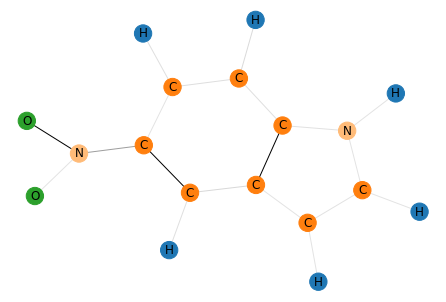

In [6]:
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)

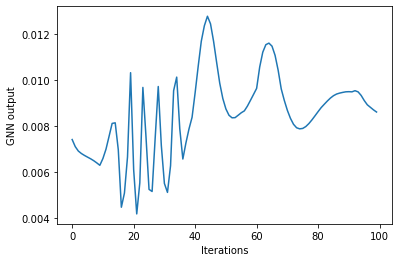

In [7]:
# Plot predicion
plt.figure()
plt.plot(inspection_result['predictions'])
plt.xlabel('Iterations')
plt.ylabel('GNN output')
plt.show()

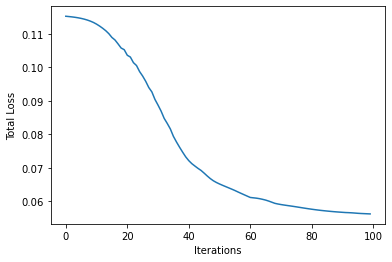

In [8]:
# PLot loss
plt.figure()
plt.plot(inspection_result['total_loss'])
plt.xlabel('Iterations')
plt.ylabel('Total Loss')
plt.show()

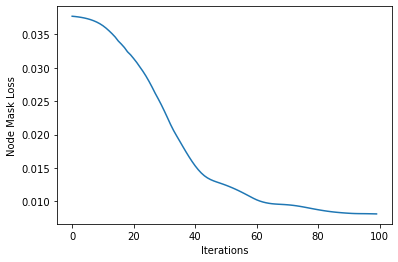

In [9]:
# Plot Edge Mask loss
plt.figure()
plt.plot(inspection_result['edge_mask_loss'])
plt.xlabel('Iterations')
plt.ylabel('Node Mask Loss')
plt.show()

sample 200 mutagenic molecules:

In [10]:
pred = model.predict(xtest)[:,0]
sampled_mutagenic_molecules = np.random.choice(np.argwhere(pred < 0.5)[:,0], 200)
print(sampled_mutagenic_molecules)

[441 118 260 281  53 608 543 567  24 118 178  35 511 205 415 490 407 352
  82 457 616 554 840 647 698 530 809 807 230  77  87 571  87  39 300 303
 599 811 333 281 198  67 106 369 110 718  59 603 578 554 427 143 689 839
 687 170 312 548  45 650 584 703 403 807 634 534  85 307 689  87 372 303
 451 691 777 169   4 507 171 528 419 300 346  41 824 833 282 505  17 244
 856 524 171 401 661 170 272 805 693 808 343 643 417 177 457 500 605 622
  31 467  67 579 506 145 490 567 517  33 409  68 856 339 652 383 540  80
 438 111 668 739 750 284  51 113  18 347 331 775 323 237 547 372 537   6
 463  51 391  98  36  61 772 152 605 668 383 336 825 839  72 714 187 554
 442 169 421 566 199 488 699 760 694 154 767 316  86 715  68 517  67 247
 810 475  15 449 171 809 143 187 409 113 536 691 860  15  45 691 450  24
 594 152]


Generate explanations for all those 50 molecules (this will take a while):

In [11]:
explanations = []
for i,mol_index in enumerate(sampled_mutagenic_molecules):
    explainer.explain([tensor[mol_index:mol_index+1] for tensor in xtest])
    print(i, end=',')
    explanations.append(explainer.get_explanation())

0,WARNING:tensorflow:5 out of the last 409 calls to <function segment_ops_by_name at 0x0000016C89DF0288> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1,WARNING:tensorflow:6 out of the last 410 calls to <function segment_ops_by_name at 0x0000016C89DF0288> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with diffe

We transform the explanation graphs to vectors, in order to apply a cluster algorithm on the explanation vectors:

In [12]:
def explanation_to_vector(explanation):
    graph = explanation[0]
    bond_matrix = np.zeros((14,14))
    for (u, v, relevance) in graph.edges.data('relevance'):
        atom1 = np.argwhere(graph.nodes[u]['features']==1)[0]
        atom2 = np.argwhere(graph.nodes[v]['features']==1)[0]
        bond_matrix[atom1, atom2] += relevance
        bond_matrix[atom2, atom1] += relevance
    bond_vector = bond_matrix[np.triu_indices(bond_matrix.shape[0])]
    bond_vector = bond_vector / np.sum(bond_vector)
    return bond_vector
explanation_vectors = [explanation_to_vector(expl) for expl in explanations]

a dendogram of the explanation vectors:

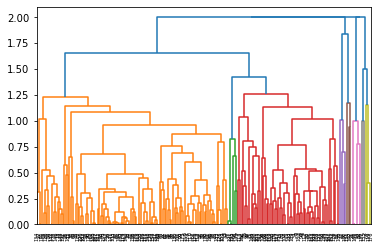

In [13]:
plt.figure()
linked = linkage(explanation_vectors, 'complete', metric='cityblock')
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

Print one representative graph explanation for each cluster:

(67, 105)


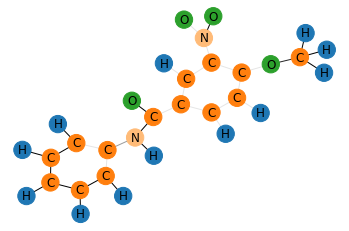

(3, 105)


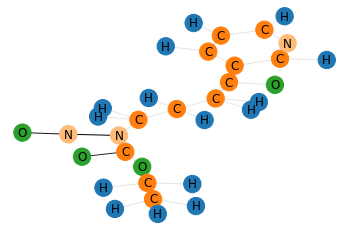

(114, 105)


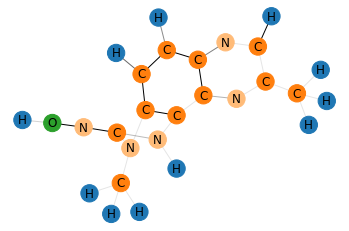

(4, 105)


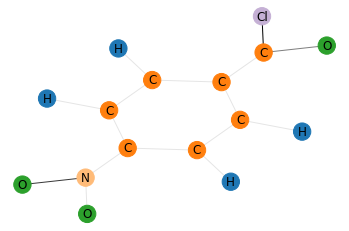

(4, 105)


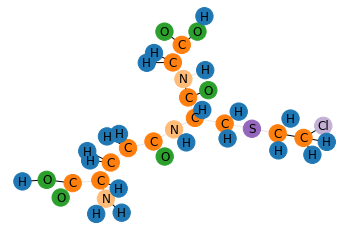

(6, 105)


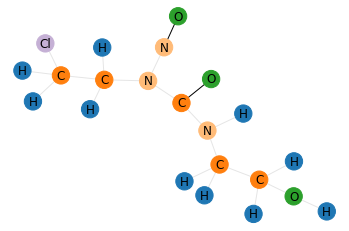

(2, 105)


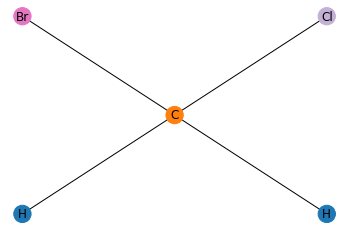

In [14]:
num_clusters = 7
db = AgglomerativeClustering(n_clusters=num_clusters, affinity='manhattan', linkage='complete').fit(explanation_vectors)
vector_clusters = []
explanation_clusters = []
for cluster_ind in range(num_clusters):
    plt.figure()
    vector_cluster = np.array([explanation_vectors[i] for i in np.argwhere(db.labels_ == cluster_ind)[:,0]])
    vector_clusters.append(vector_cluster)
    explanation_cluster = [explanations[i] for i in np.argwhere(db.labels_ == cluster_ind)[:,0]]
    explanation_clusters.append(explanation_cluster)
    cluster_mean = np.mean(vector_cluster, axis=0)
    dist = cdist(np.array([cluster_mean]), vector_cluster)[0]
    print(vector_cluster.shape)
    ax = plt.subplot()
    explainer.present_explanation(explanation_cluster[np.argmin(dist)])
    plt.show()